<a href="https://colab.research.google.com/github/zentralwerkstatt/fau/blob/main/fau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Clustering with Large Visual Models

**This notebook requires a GPU - make sure to change the runtime type in the "runtime" menu!**

## Setup

Access utility functions

In [1]:
%%capture
!rm -rf toolbox
!git clone https://github.com/zentralwerkstatt/toolbox
!pip3 install git+https://github.com/openai/CLIP.git
!pip3 install umap-learn filetype

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

Imports

In [2]:
import numpy as np
import PIL.Image
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from toolbox import toolbox
from IPython.display import display

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 49.9MiB/s]


Getting some test data "locally" (Web gallery of art)


In [3]:
%%capture
!rm -rf wga
!gdown --id 10eyHTKDDqN7iwu0WDCaq2sZtOCQ3w9Fs
!unzip wga.zip -d .
!rm wga.zip

## What is an image anyway?


In [4]:
# Let's get a test image
img = toolbox.img_from_url("https://c.files.bbci.co.uk/8D30/production/_106344163_florida_python_.big_cypressjpg.jpg")

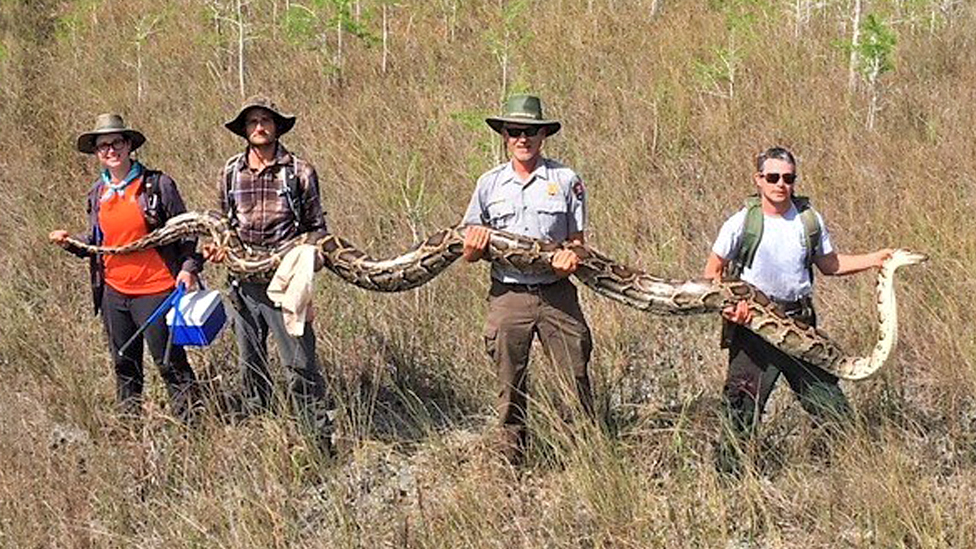

In [5]:
img

In Python, images are arrays, i.e. multi-dimensional matrices. Color images have three channels.

In [11]:
print(np.array(img))

[[[129 115  78]
  [147 137  88]
  [153 147  89]
  ...
  [166 148 108]
  [150 131  91]
  [159 139 102]]

 [[137 121  87]
  [149 135  90]
  [158 147  93]
  ...
  [167 149 111]
  [157 139 101]
  [169 149 112]]

 [[131 112  79]
  [139 122  79]
  [154 141  89]
  ...
  [165 147 109]
  [176 158 120]
  [188 168 133]]

 ...

 [[106  86  53]
  [116  96  61]
  [141 123  87]
  ...
  [155 123  85]
  [149 116  83]
  [152 121  90]]

 [[ 90  70  37]
  [110  91  58]
  [139 121  85]
  ...
  [154 121  86]
  [160 127  94]
  [178 144 116]]

 [[ 97  77  44]
  [115  96  63]
  [137 119  83]
  ...
  [159 126  91]
  [170 137 104]
  [195 161 133]]]


## Clustering images...

First, load the WGA dataset

In [12]:
paths = toolbox.get_all_files("wga", ext="jpg")
print(paths[:5])

['wga/train/portrait/99.jpg', 'wga/train/portrait/244.jpg', 'wga/train/portrait/655.jpg', 'wga/train/portrait/247.jpg', 'wga/train/portrait/871.jpg']


In [13]:
len(paths)

2200

Let's try everything with a small subset first

In [14]:
paths = paths[:100]

### ... by "brightness"

Extract the features by "flattening" the image - we are simply concatenating all color values into one huge list.

In [15]:
features = np.zeros((len(paths), 32*32*3))
for i, path in enumerate(tqdm(paths)):
    img = toolbox.load_img(path)
    features[i] = toolbox.flatten_img(img, 32)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
print(features.shape)

(100, 3072)


This gives us 3072-dimensional features, we have to reduce them down to Euclidean space somehow. We will use the [UMAP algorithm](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection) for this.

In [17]:
reduced_features = toolbox.reduce_features(features)
print(reduced_features.shape)

(100, 2)


Now let's see how that looks

In [18]:
plot = toolbox.plot_imgs_features(paths, 50, reduced_features)

  0%|          | 0/100 [00:00<?, ?it/s]

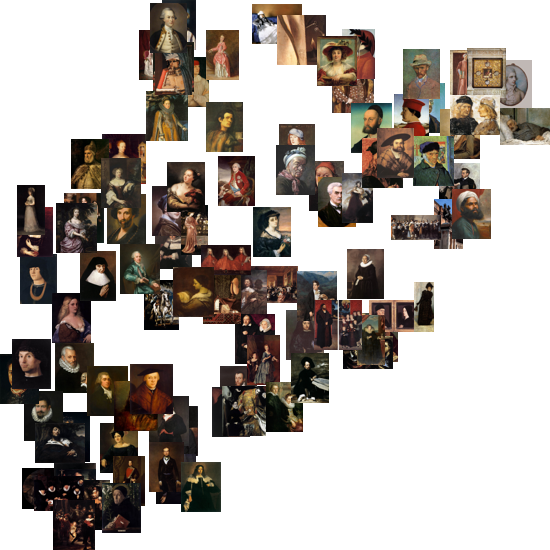

In [19]:
plot

In [ ]:
plot.save("plot_raw.jpg")

### ... using CLIP

Usually, however, color will not tell us much about an image dataset. Instead, we can leverage state-of-the-art, fully-trained neural networks, like [CLIP](https://openai.com/blog/clip/), that know something about the *content* of images.

In [20]:
features = np.zeros((len(paths), 512))
for i, path in enumerate(tqdm(paths)):
    img = toolbox.load_img(path)
    features[i] = toolbox.CLIP_img(img)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
print(features.shape)

(100, 512)


CLIP gives us 512-dimensional embeddings, we have to reduce them down to Euclidean space somehow. Again we will use the UMAP algorithm.

In [22]:
reduced_features = toolbox.reduce_features(features)
print(reduced_features.shape)

(100, 2)


In [25]:
plot = toolbox.plot_imgs_features(paths, 50, reduced_features)

  0%|          | 0/100 [00:00<?, ?it/s]

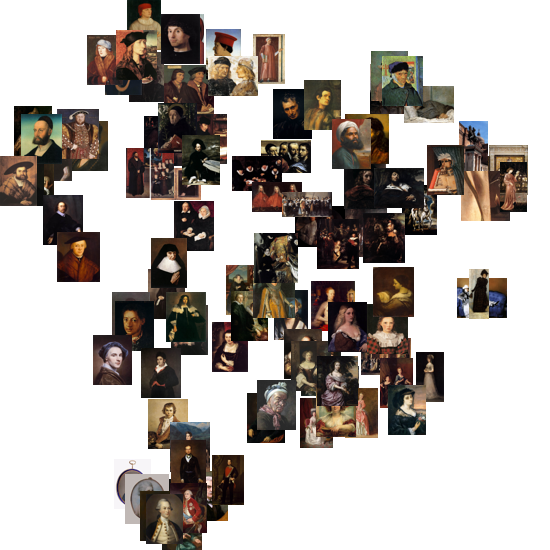

In [26]:
plot

In [ ]:
plot.save("plot_clip.jpg")

## Advanced clustering

There are many interesting clusters that we can see in the plot - can we automate this process, too?

In [ ]:
n_clusters = 20

In [ ]:
km = KMeans(n_clusters=n_clusters)
km.fit(features)

In [ ]:
km.labels_.shape

We are trying to find 5 clusters in 2200 images - here is what the algorihtm found

In [ ]:
km.labels_[:100]

Let's try to visualize this

In [ ]:
clusters = {}
for c in range(n_clusters):
    clusters[c] = []
    for i, path in enumerate(paths):
        if km.labels_[i] == c:
            clusters[c].append(path)

In [ ]:
for c in range(n_clusters):
    toolbox.show_img(toolbox.plot_imgs_grid(clusters[c], 50))

No we will visualize where the clusters are in the overview plot

In [ ]:
borders = []
p = toolbox.random_palette(n_clusters)
for i, path in enumerate(paths):
    borders.append(p[km.labels_[i]])

In [ ]:
plot = toolbox.plot_imgs_features(paths, 50, reduced_features, borders)

In [ ]:
plot

In [ ]:
plot.save("plot_clip_borders_clusters.jpg")

Finally, we can use the colored borders to add metadata back in!

In [ ]:
borders = []
p = toolbox.random_palette(2)
for i, path in enumerate(paths):
    if "Screen" in path:
        borders.append(p[0])
    else:
        borders.append(p[1])

In [ ]:
plot = toolbox.plot_imgs_features(paths, 50, reduced_features, borders)

In [ ]:
plot

In [ ]:
plot.save("plot_clip_borders_classes.jpg")